In [1]:
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.io as pio
import plotly.graph_objects as go

from collections import defaultdict
from pathlib import Path
import pandas as pd
import numpy as np
from typing import *

import statsmodels.api as sm
import scipy.stats as stats
from scipy.stats import boxcox
from scipy.special import inv_boxcox

import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.feature_selection import RFECV
from sklearn.model_selection import KFold

from sklearn.model_selection import train_test_split
from sklearn.metrics import *

pio.renderers.default = "iframe"

In [2]:
base_path = "/data/saturation/central_composite_design/ccd9"
base_path_holdout = "/data/saturation/central_composite_design/ccd9_holdout"

dvs = ["areal_density", "n_craters_in_study_region", "z", "za"]
ivs = ["slope", "effective_radius_multiplier", "r_stat_multiplier", "min_rim_percentage"]
alphas = [0.01, 0.05, 0.25, 0.5]
sample_size = 1000
metric = "n_craters_in_study_region"

In [3]:
train_df = pd.read_csv(f"{base_path}/post_saturation_sample_{sample_size}.csv")

# First test_df contains simulations that are near the vertices of the CCD
# Second test_df contains simulations that are in the midpoints of CCD levels
test_dfs = [
    pd.read_csv(f"{base_path}/post_saturation_in_sample_holdout_sample_{sample_size}.csv"),
    pd.read_csv(f"{base_path_holdout}/post_saturation_sample_{sample_size}.csv")
]

### Linear regression models

In [4]:
def fit_and_report_statsmodels_model(fit_func: Callable[[pd.DataFrame, pd.DataFrame], Any],
                                     alpha: float,
                                     X_train: pd.DataFrame,
                                     y_train: pd.DataFrame,
                                     X_tests: pd.DataFrame,
                                     y_tests: pd.DataFrame,
                                     model_name: str,
                                     transform=lambda x: x,
                                     inverse_transform=lambda x: x):
    y_train_transformed = transform(y_train)
    
    model = fit_func(y_train_transformed, X_train)
    print(model.summary())

    print(f"*** Train set")
    y_pred = inverse_transform(model.predict(X_train))
    percent_below = (y_train < y_pred).mean() * 100
    print(f"Alpha = {alpha:.2f}, % below: {percent_below:.2f}")
        
    for indx, (X_test, y_test) in enumerate(zip(X_tests, y_tests)):
        print(f"*** Test set {indx + 1}")
        y_pred = inverse_transform(model.predict(X_test))
        percent_below = (y_test < y_pred).mean() * 100
        print(f"Alpha = {alpha:.2f}, % below: {percent_below:.2f}")
    
    return model

#### Checking scatterplots

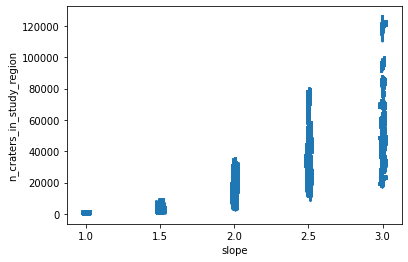

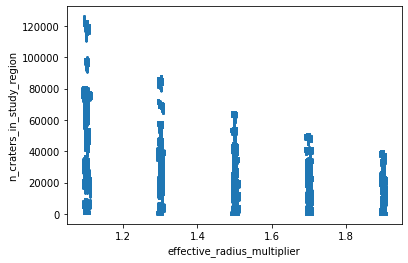

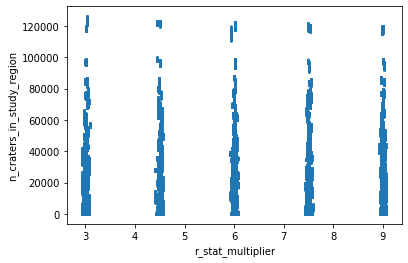

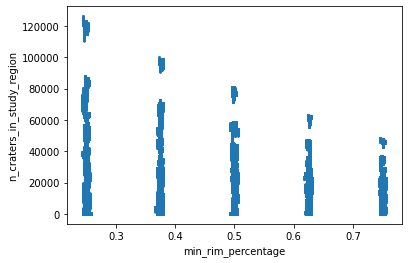

In [5]:
series = train_df[metric]

for iv in ivs:
    plt.scatter(train_df[iv], series, s=1)
    plt.xlabel(iv)
    plt.ylabel(metric)
    plt.show()

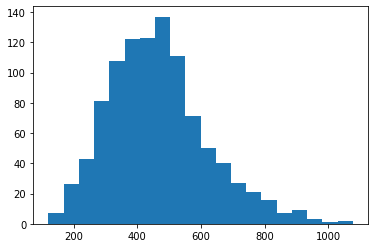

In [6]:
plt.hist(train_df[train_df.simulation_id == 26][metric], bins=20)
plt.show()

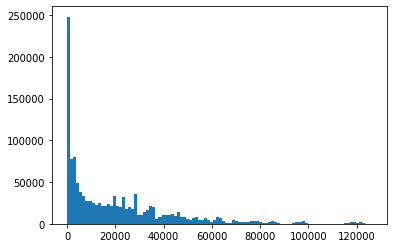

In [7]:
plt.hist(train_df[metric], bins=100)
plt.show()

### Baseline Linear Regression Model

In [9]:
alpha = 0.05

X_train = train_df[ivs]
X_tests = [x[ivs] for x in test_dfs]

y_train = train_df[metric]
y_tests = [x[metric] for x in test_dfs]

model = fit_and_report_statsmodels_model(lambda y, x: sm.QuantReg(y, x).fit(alpha),
                                         alpha,
                                         sm.add_constant(X_train),
                                         y_train,
                                         [sm.add_constant(x) for x in X_tests],
                                         y_tests,
                                         "LM No Interactions",
                                         transform=lambda x: x,
                                         inverse_transform=lambda x: x)

                             QuantReg Regression Results                             
Dep. Variable:     n_craters_in_study_region   Pseudo R-squared:               0.4443
Model:                              QuantReg   Bandwidth:                       244.0
Method:                        Least Squares   Sparsity:                    1.685e+04
Date:                       Sun, 28 May 2023   No. Observations:              1256298
Time:                               22:54:48   Df Residuals:                  1256293
                                               Df Model:                            4
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const                       -6084.1095     36.118   -168.453      0.000   -6154.899   -6013.320
slope                        1.624e+04      4.087   3973.854      0.000    1.62e+04    1.63e+04
effective_radi

### With Interactions

In [9]:
alpha = 0.05
exclude = {}

features = [x for x in ivs if x not in exclude]

X_train = train_df[features]
X_tests = [x[features] for x in test_dfs]

y_train = train_df[metric]
y_tests = [x[metric] for x in test_dfs]

min_max_scaler = sklearn.preprocessing.MinMaxScaler()
X_train = min_max_scaler.fit_transform(X_train)
X_train = pd.DataFrame(X_train, columns=min_max_scaler.get_feature_names_out())

poly_transform = sklearn.preprocessing.PolynomialFeatures(degree=2, include_bias=False)
X_train = poly_transform.fit_transform(X_train)
X_train = pd.DataFrame(X_train, columns=poly_transform.get_feature_names_out())

X_tests = [pd.DataFrame(min_max_scaler.transform(x), columns=min_max_scaler.get_feature_names_out()) for x in X_tests]
X_tests = [poly_transform.transform(x) for x in X_tests]
X_tests = [pd.DataFrame(x, columns=poly_transform.get_feature_names_out()) for x in X_tests]

model = fit_and_report_statsmodels_model(lambda y, x: sm.QuantReg(y, x).fit(alpha),
                                         alpha,
                                         sm.add_constant(X_train),
                                         y_train,
                                         [sm.add_constant(x) for x in X_tests],
                                         y_tests,
                                         "LM All Interactions",
                                         transform=lambda x: x,
                                         inverse_transform=lambda x: x)

                             QuantReg Regression Results                             
Dep. Variable:     n_craters_in_study_region   Pseudo R-squared:               0.7388
Model:                              QuantReg   Bandwidth:                       643.5
Method:                        Least Squares   Sparsity:                        5971.
Date:                       Sun, 28 May 2023   No. Observations:                16362
Time:                               22:07:25   Df Residuals:                    16347
                                               Df Model:                           14
                                                     coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------
const                                            437.1900     46.850      9.332      0.000     345.358     529.022
slope                                           3.014

#### Removing Insignificant Variables

In [10]:
alpha = 0.01
add_const = False

exclude = {
    "effective_radius_multiplier r_stat_multiplier", # effect size
    "r_stat_multiplier^2", # effect size
    "slope r_stat_multiplier", # effect size
    "r_stat_multiplier min_rim_percentage", # effect size
    "effective_radius_multiplier min_rim_percentage", # effect size
    "r_stat_multiplier", # effect size
    "const", # effect size
    "min_rim_percentage^2", # effect size
}

X_train = train_df[ivs]
X_tests = [x[ivs] for x in test_dfs]

y_train = train_df[metric]
y_tests = [x[metric] for x in test_dfs]

min_max_scaler = sklearn.preprocessing.MinMaxScaler()
X_train = min_max_scaler.fit_transform(X_train)
X_train = pd.DataFrame(X_train, columns=min_max_scaler.get_feature_names_out())

poly_transform = sklearn.preprocessing.PolynomialFeatures(degree=2, include_bias=False)
X_train = poly_transform.fit_transform(X_train)
X_train = pd.DataFrame(X_train, columns=poly_transform.get_feature_names_out())
X_train = X_train[[x for x in X_train.columns if x not in exclude]]

X_tests = [pd.DataFrame(min_max_scaler.transform(x), columns=min_max_scaler.get_feature_names_out()) for x in X_tests]
X_tests = [poly_transform.transform(x) for x in X_tests]
X_tests = [pd.DataFrame(x, columns=poly_transform.get_feature_names_out()) for x in X_tests]
X_tests = [x[[y for y in x.columns if y not in exclude]] for x in X_tests]

model = fit_and_report_statsmodels_model(lambda y, x: sm.QuantReg(y, x).fit(alpha),
                                         alpha,
                                         sm.add_constant(X_train) if add_const else X_train,
                                         y_train,
                                         [sm.add_constant(x) if add_const else x for x in X_tests],
                                         y_tests,
                                         "LM Reduced Interactions",
                                         transform=lambda x: x,
                                         inverse_transform=lambda x: x)

                             QuantReg Regression Results                             
Dep. Variable:     n_craters_in_study_region   Pseudo R-squared:               0.6084
Model:                              QuantReg   Bandwidth:                       284.7
Method:                        Least Squares   Sparsity:                    1.895e+04
Date:                       Sun, 28 May 2023   No. Observations:              1256298
Time:                               22:55:18   Df Residuals:                  1256291
                                               Df Model:                            7
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
slope                              1.122e+04     21.963    510.651      0.000    1.12e+04    1.13e+04
effective_radius_multiplier       -2068.3685     18.480   -111.926      0.000   -2104.588   

In [11]:
# Checking effect sizes
max_coef = max([abs(x) for x, y in zip(model.params, model.params.index) if y != "const"])
sorted([(abs(x / max_coef), y) for x, y in zip(model.params, model.params.index)])

[(0.0169747417876449, 'min_rim_percentage'),
 (0.0375292186329376, 'effective_radius_multiplier^2'),
 (0.04091631837490243, 'effective_radius_multiplier'),
 (0.22185838718429474, 'slope'),
 (0.41555502106869324, 'slope min_rim_percentage'),
 (0.4835290865266628, 'slope effective_radius_multiplier'),
 (1.0, 'slope^2')]

In [12]:
# Checking highest p-value
model.pvalues.sort_values(ascending=False)

slope                                0.0
effective_radius_multiplier          0.0
min_rim_percentage                   0.0
slope^2                              0.0
slope effective_radius_multiplier    0.0
slope min_rim_percentage             0.0
effective_radius_multiplier^2        0.0
dtype: float64

In [115]:
alpha = 0.05
add_const = False # effect size

exclude = {
    "slope r_stat_multiplier", # p-value
    "effective_radius_multiplier r_stat_multiplier", # p-value
    "r_stat_multiplier min_rim_percentage", # effect size
    "const", # effect size
    "r_stat_multiplier^2", # effect size
    "r_stat_multiplier", # effect size
    "effective_radius_multiplier min_rim_percentage", # effect size
    "min_rim_percentage^2", # effect size
}

X_train = train_df[ivs]
X_tests = [x[ivs] for x in test_dfs]

y_train = train_df[metric]
y_tests = [x[metric] for x in test_dfs]

min_max_scaler = sklearn.preprocessing.MinMaxScaler()
X_train = min_max_scaler.fit_transform(X_train)
X_train = pd.DataFrame(X_train, columns=min_max_scaler.get_feature_names_out())

poly_transform = sklearn.preprocessing.PolynomialFeatures(degree=2, include_bias=False)
X_train = poly_transform.fit_transform(X_train)
X_train = pd.DataFrame(X_train, columns=poly_transform.get_feature_names_out())
X_train = X_train[[x for x in X_train.columns if x not in exclude]]

X_tests = [pd.DataFrame(min_max_scaler.transform(x), columns=min_max_scaler.get_feature_names_out()) for x in X_tests]
X_tests = [poly_transform.transform(x) for x in X_tests]
X_tests = [pd.DataFrame(x, columns=poly_transform.get_feature_names_out()) for x in X_tests]
X_tests = [x[[y for y in x.columns if y not in exclude]] for x in X_tests]

model = fit_and_report_statsmodels_model(lambda y, x: sm.QuantReg(y, x).fit(alpha, max_iter=10000),
                                         alpha,
                                         sm.add_constant(X_train) if add_const else X_train,
                                         y_train,
                                         [sm.add_constant(x) if add_const else x for x in X_tests],
                                         y_tests,
                                         "LM Reduced Interactions",
                                         transform=lambda x: x,
                                         inverse_transform=lambda x: x)

                             QuantReg Regression Results                             
Dep. Variable:     n_craters_in_study_region   Pseudo R-squared:               0.7345
Model:                              QuantReg   Bandwidth:                       661.2
Method:                        Least Squares   Sparsity:                        6381.
Date:                       Sun, 28 May 2023   No. Observations:                16362
Time:                               22:22:50   Df Residuals:                    16355
                                               Df Model:                            7
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
slope                              3.089e+04    103.147    299.518      0.000    3.07e+04    3.11e+04
effective_radius_multiplier       -1.036e+04     91.925   -112.736      0.000   -1.05e+04   

In [116]:
# Checking effect sizes
max_coef = max([abs(x) for x, y in zip(model.params, model.params.index) if y != "const"])
sorted([(abs(x / max_coef), y) for x, y in zip(model.params, model.params.index)])

[(0.016308203181822925, 'min_rim_percentage'),
 (0.22387139500093492, 'effective_radius_multiplier^2'),
 (0.22680096705241218, 'effective_radius_multiplier'),
 (0.5189871962521427, 'slope min_rim_percentage'),
 (0.6761273731013168, 'slope'),
 (0.8512190960819324, 'slope effective_radius_multiplier'),
 (1.0, 'slope^2')]

In [117]:
# Checking highest p-value
model.pvalues.sort_values(ascending=False)

min_rim_percentage                   8.944085e-85
slope                                0.000000e+00
effective_radius_multiplier          0.000000e+00
slope^2                              0.000000e+00
slope effective_radius_multiplier    0.000000e+00
slope min_rim_percentage             0.000000e+00
effective_radius_multiplier^2        0.000000e+00
dtype: float64

In [118]:
alpha = 0.25
add_const = False

exclude = {
    "slope r_stat_multiplier", # effect size
    "effective_radius_multiplier r_stat_multiplier", # effect size
    "r_stat_multiplier^2", # effect size
    "r_stat_multiplier", # effect size
    "r_stat_multiplier min_rim_percentage", # effect size
    "const", # effect size
    "effective_radius_multiplier min_rim_percentage", # effect size
    "min_rim_percentage^2", # effect size
}

X_train = train_df[ivs]
X_tests = [x[ivs] for x in test_dfs]

y_train = train_df[metric]
y_tests = [x[metric] for x in test_dfs]

min_max_scaler = sklearn.preprocessing.MinMaxScaler()
X_train = min_max_scaler.fit_transform(X_train)
X_train = pd.DataFrame(X_train, columns=min_max_scaler.get_feature_names_out())

poly_transform = sklearn.preprocessing.PolynomialFeatures(degree=2, include_bias=False)
X_train = poly_transform.fit_transform(X_train)
X_train = pd.DataFrame(X_train, columns=poly_transform.get_feature_names_out())
X_train = X_train[[x for x in X_train.columns if x not in exclude]]

X_tests = [pd.DataFrame(min_max_scaler.transform(x), columns=min_max_scaler.get_feature_names_out()) for x in X_tests]
X_tests = [poly_transform.transform(x) for x in X_tests]
X_tests = [pd.DataFrame(x, columns=poly_transform.get_feature_names_out()) for x in X_tests]
X_tests = [x[[y for y in x.columns if y not in exclude]] for x in X_tests]

model = fit_and_report_statsmodels_model(lambda y, x: sm.QuantReg(y, x).fit(alpha, max_iter=10000),
                                         alpha,
                                         sm.add_constant(X_train) if add_const else X_train,
                                         y_train,
                                         [sm.add_constant(x) if add_const else x for x in X_tests],
                                         y_tests,
                                         "LM Reduced Interactions",
                                         transform=lambda x: x,
                                         inverse_transform=lambda x: x)

                             QuantReg Regression Results                             
Dep. Variable:     n_craters_in_study_region   Pseudo R-squared:               0.7864
Model:                              QuantReg   Bandwidth:                       541.8
Method:                        Least Squares   Sparsity:                        3981.
Date:                       Sun, 28 May 2023   No. Observations:                16362
Time:                               22:22:56   Df Residuals:                    16355
                                               Df Model:                            7
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
slope                              3.849e+04    122.891    313.169      0.000    3.82e+04    3.87e+04
effective_radius_multiplier       -4239.6724    113.333    -37.409      0.000   -4461.817   

In [119]:
# Checking effect sizes
max_coef = max([abs(x) for x, y in zip(model.params, model.params.index) if y != "const"])
sorted([(abs(x / max_coef), y) for x, y in zip(model.params, model.params.index)])

[(0.021116873620350984, 'min_rim_percentage'),
 (0.10004060379477163, 'effective_radius_multiplier'),
 (0.1014457312618432, 'effective_radius_multiplier^2'),
 (0.6473628292135617, 'slope min_rim_percentage'),
 (0.9081195518030244, 'slope'),
 (0.9707072184288178, 'slope effective_radius_multiplier'),
 (1.0, 'slope^2')]

In [120]:
# Checking highest p-value
model.pvalues.sort_values(ascending=False)

min_rim_percentage                    1.602475e-83
effective_radius_multiplier^2        1.180427e-286
effective_radius_multiplier          5.851157e-294
slope                                 0.000000e+00
slope^2                               0.000000e+00
slope effective_radius_multiplier     0.000000e+00
slope min_rim_percentage              0.000000e+00
dtype: float64

In [124]:
alpha = 0.5
add_const = False # effect size

exclude = {
    "effective_radius_multiplier r_stat_multiplier", # p-value
    "r_stat_multiplier^2", # p-value
    "slope r_stat_multiplier", # p-value
    "r_stat_multiplier min_rim_percentage", # effect size
    "r_stat_multiplier", # p-value
    "min_rim_percentage^2", # effect size
    "const", # effect size
}

X_train = train_df[ivs]
X_tests = [x[ivs] for x in test_dfs]

y_train = train_df[metric]
y_tests = [x[metric] for x in test_dfs]

min_max_scaler = sklearn.preprocessing.MinMaxScaler()
X_train = min_max_scaler.fit_transform(X_train)
X_train = pd.DataFrame(X_train, columns=min_max_scaler.get_feature_names_out())

poly_transform = sklearn.preprocessing.PolynomialFeatures(degree=2, include_bias=False)
X_train = poly_transform.fit_transform(X_train)
X_train = pd.DataFrame(X_train, columns=poly_transform.get_feature_names_out())
X_train = X_train[[x for x in X_train.columns if x not in exclude]]

X_tests = [pd.DataFrame(min_max_scaler.transform(x), columns=min_max_scaler.get_feature_names_out()) for x in X_tests]
X_tests = [poly_transform.transform(x) for x in X_tests]
X_tests = [pd.DataFrame(x, columns=poly_transform.get_feature_names_out()) for x in X_tests]
X_tests = [x[[y for y in x.columns if y not in exclude]] for x in X_tests]

model = fit_and_report_statsmodels_model(lambda y, x: sm.QuantReg(y, x).fit(alpha, max_iter=10000),
                                         alpha,
                                         sm.add_constant(X_train) if add_const else X_train,
                                         y_train,
                                         [sm.add_constant(x) if add_const else x for x in X_tests],
                                         y_tests,
                                         "LM Reduced Interactions",
                                         transform=lambda x: x,
                                         inverse_transform=lambda x: x)

                             QuantReg Regression Results                             
Dep. Variable:     n_craters_in_study_region   Pseudo R-squared:               0.8071
Model:                              QuantReg   Bandwidth:                       560.3
Method:                        Least Squares   Sparsity:                        5349.
Date:                       Sun, 28 May 2023   No. Observations:                16362
Time:                               22:23:27   Df Residuals:                    16354
                                               Df Model:                            8
                                                     coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------
slope                                           4.908e+04    182.731    268.603      0.000    4.87e+04    4.94e+04
effective_radius_multiplier                    -1.354

In [125]:
# Checking effect sizes
max_coef = max([abs(x) for x, y in zip(model.params, model.params.index) if y != "const"])
sorted([(abs(x / max_coef), y) for x, y in zip(model.params, model.params.index)])

[(0.016030446701984783, 'min_rim_percentage'),
 (0.1985096186451557, 'effective_radius_multiplier min_rim_percentage'),
 (0.2757904995490038, 'effective_radius_multiplier'),
 (0.2784009972368906, 'effective_radius_multiplier^2'),
 (0.6787370359382712, 'slope min_rim_percentage'),
 (0.811085936582921, 'slope^2'),
 (0.9810039838332558, 'slope effective_radius_multiplier'),
 (1.0, 'slope')]

In [126]:
# Checking highest p-value
model.pvalues.sort_values(ascending=False)

min_rim_percentage                                9.598161e-24
slope                                             0.000000e+00
effective_radius_multiplier                       0.000000e+00
slope^2                                           0.000000e+00
slope effective_radius_multiplier                 0.000000e+00
slope min_rim_percentage                          0.000000e+00
effective_radius_multiplier^2                     0.000000e+00
effective_radius_multiplier min_rim_percentage    0.000000e+00
dtype: float64

### Using Recursive Feature Elimination With Interactions

In [128]:
alpha = 0.05

exclude = {}

X_train = train_df[ivs]
X_tests = [x[ivs] for x in test_dfs]

y_train = train_df[metric]
y_tests = [x[metric] for x in test_dfs]

min_max_scaler = sklearn.preprocessing.MinMaxScaler()
X_train = min_max_scaler.fit_transform(X_train)
X_train = pd.DataFrame(X_train, columns=min_max_scaler.get_feature_names_out())

poly_transform = sklearn.preprocessing.PolynomialFeatures(degree=3, include_bias=False)
X_train = poly_transform.fit_transform(X_train)
X_train = pd.DataFrame(X_train, columns=poly_transform.get_feature_names_out())
X_train = X_train[[x for x in X_train.columns if x not in exclude]]

X_tests = [pd.DataFrame(min_max_scaler.transform(x), columns=min_max_scaler.get_feature_names_out()) for x in X_tests]
X_tests = [poly_transform.transform(x) for x in X_tests]
X_tests = [pd.DataFrame(x, columns=poly_transform.get_feature_names_out()) for x in X_tests]
X_tests = [x[[y for y in x.columns if y not in exclude]] for x in X_tests]

In [129]:
import statsmodels.api as sm
from sklearn.base import BaseEstimator, RegressorMixin

class SMWrapper(BaseEstimator, RegressorMixin):
    """ A universal sklearn-style wrapper for statsmodels regressors """
    def __init__(self, model_class, fit_kwargs={}):
        self.model_class = model_class
        self.fit_kwargs = fit_kwargs
        
    def fit(self, X, y):
        self.model_ = self.model_class(y, X)
        self.results_ = self.model_.fit(**self.fit_kwargs)
        return self
    
    def predict(self, X):
        return self.results_.predict(X)
    
    @property
    def coef_(self):
        return self.results_.params

In [130]:
def get_scorer(alpha: float, inverse_transform=lambda x: x):
    def internal_scorer(model, X, y):
        y_pred = inverse_transform(model.predict(X))
        score = ((y < y_pred).mean() - alpha)**2
        return -score
    
    return internal_scorer

In [131]:
min_features_to_select = 1 
model = SMWrapper(sm.QuantReg, fit_kwargs={"q": alpha})
cv = KFold(5)

rfecv = RFECV(
    estimator=model,
    step=1,
    cv=cv,
    scoring=get_scorer(alpha, inverse_transform=lambda x: x),
    min_features_to_select=min_features_to_select,
    n_jobs=15
)
rfecv.fit(X_train, y_train)

/home/mason/code/saturation/venv/lib/python3.10/site-packages/statsmodels/regression/quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +
/home/mason/code/saturation/venv/lib/python3.10/site-packages/statsmodels/regression/quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +
/home/mason/code/saturation/venv/lib/python3.10/site-packages/statsmodels/regression/quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +
/home/mason/code/saturation/venv/lib/python3.10/site-packages/statsmodels/regression/quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +
/home/ma

RFECV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
      estimator=SMWrapper(fit_kwargs={'q': 0.05},
                          model_class=<class 'statsmodels.regression.quantile_regression.QuantReg'>),
      n_jobs=15,
      scoring=<function get_scorer.<locals>.internal_scorer at 0x7f3d82c9a710>)

In [132]:
model = fit_and_report_statsmodels_model(lambda y, x: sm.QuantReg(y, x).fit(alpha),
                                         alpha,
                                         sm.add_constant(X_train)[rfecv.get_feature_names_out()],
                                         y_train,
                                         [sm.add_constant(x)[rfecv.get_feature_names_out()] for x in X_tests],
                                         y_tests,
                                         "LM With RFE Features",
                                         transform=lambda x: x,
                                         inverse_transform=lambda x: x)

                             QuantReg Regression Results                             
Dep. Variable:     n_craters_in_study_region   Pseudo R-squared:               0.7677
Model:                              QuantReg   Bandwidth:                       603.3
Method:                        Least Squares   Sparsity:                        5567.
Date:                       Sun, 28 May 2023   No. Observations:                16362
Time:                               22:25:55   Df Residuals:                    16358
                                               Df Model:                            4
                                                           coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------
slope^2                                               9.097e+04     22.562   4031.786      0.000    9.09e+04     9.1e+04
slope^2 effective_radius_multiplier

### Plotting Prediction Intervals

In [37]:
X_train = train_df[ivs]
X_tests = [x[ivs] for x in test_dfs]

y_train = train_df[metric]
y_tests = [x[metric] for x in test_dfs]

min_max_scaler = sklearn.preprocessing.MinMaxScaler()
X_train = min_max_scaler.fit_transform(X_train)
X_train = pd.DataFrame(X_train, columns=min_max_scaler.get_feature_names_out())

poly_transform = sklearn.preprocessing.PolynomialFeatures(degree=2, include_bias=False)
X_train = poly_transform.fit_transform(X_train)
X_train = pd.DataFrame(X_train, columns=poly_transform.get_feature_names_out())
X_train = sm.add_constant(X_train)

X_tests = [pd.DataFrame(min_max_scaler.transform(x), columns=min_max_scaler.get_feature_names_out()) for x in X_tests]
X_tests = [poly_transform.transform(x) for x in X_tests]
X_tests = [pd.DataFrame(x, columns=poly_transform.get_feature_names_out()) for x in X_tests]
X_tests = [sm.add_constant(x) for x in X_tests]

In [38]:
model_configs = {
    0.01: {
        "exclude_features": {
            "effective_radius_multiplier r_stat_multiplier", # effect size
            "r_stat_multiplier^2", # effect size
            "slope r_stat_multiplier", # effect size
            "r_stat_multiplier min_rim_percentage", # effect size
            "effective_radius_multiplier min_rim_percentage", # effect size
            "r_stat_multiplier", # effect size
            "const", # effect size
            "min_rim_percentage^2", # effect size
        }
    },
    0.05: {
        "exclude_features": {
            "slope r_stat_multiplier", # p-value
            "effective_radius_multiplier r_stat_multiplier", # p-value
            "r_stat_multiplier min_rim_percentage", # effect size
            "const", # effect size
            "r_stat_multiplier^2", # effect size
            "r_stat_multiplier", # effect size
            "effective_radius_multiplier min_rim_percentage", # effect size
            "min_rim_percentage^2", # effect size
        }
    },
    0.25: {
        "exclude_features": {
            "slope r_stat_multiplier", # effect size
            "effective_radius_multiplier r_stat_multiplier", # effect size
            "r_stat_multiplier^2", # effect size
            "r_stat_multiplier", # effect size
            "r_stat_multiplier min_rim_percentage", # effect size
            "const", # effect size
            "effective_radius_multiplier min_rim_percentage", # effect size
            "min_rim_percentage^2", # effect size
        }
    },  
    0.5: {
        "exclude_features": {
            "effective_radius_multiplier r_stat_multiplier", # p-value
            "r_stat_multiplier^2", # p-value
            "slope r_stat_multiplier", # p-value
            "r_stat_multiplier min_rim_percentage", # effect size
            "r_stat_multiplier", # p-value
            "min_rim_percentage^2", # effect size
            "const", # effect size
        }
    },  
}

model_configs = [
    {
        "alpha": alpha,
        "model": sm.QuantReg(y_train, X_train[[x for x in X_train.columns if x not in config["exclude_features"]]]).fit(alpha, max_iter=3000),
        "exclude_features": config["exclude_features"]
    }
    for (alpha, config) in model_configs.items()
]

In [39]:
# Load up a subset of the test DFs
np.random.seed(123)

sample_cadence = 100
in_ccd_paths = list(Path(base_path).glob("simulation_*.parquet"))
outside_ccd_paths = list(Path(base_path_holdout).glob("simulation_*.parquet"))

In [46]:
def read_simulation_parquet(path: Path, sample_cadence: int) -> pd.DataFrame:
    df = pd.read_parquet(path, columns=ivs + dvs + ["simulation_id", "n_craters_added_in_study_region"])
    return df.iloc[[x * sample_cadence for x in range(df.shape[0] // sample_cadence)]].copy()


def score_models(model_configs: list,
                 df: pd.DataFrame,
                 metric: str,
                 inverse_transform,
                 add_constant: bool) -> pd.DataFrame:
    X = df[ivs]
    X = min_max_scaler.transform(X)
    X = pd.DataFrame(X, columns=min_max_scaler.get_feature_names_out())
    
    X = poly_transform.transform(X)
    X = pd.DataFrame(X, columns=poly_transform.get_feature_names_out())

    pred_df = df.reset_index(drop=True).copy()
    for feature_name in poly_transform.get_feature_names_out():
        pred_df[feature_name] = X[feature_name]
    
    y = df[metric]
    
    if add_constant:
        X = sm.add_constant(X, has_constant="add")
    pred_df["actual"] = list(y)
    pred_df["n_craters"] = list(df.index)
    
    for model_config in model_configs:
        alpha = model_config["alpha"]
        model = model_config["model"]
        exclude_features = model_config["exclude_features"]
        
        predictions = inverse_transform(model.predict(X[[x for x in X.columns if x not in exclude_features]]))
        pred_df[f"alpha_{alpha:.2f}"] = predictions
        
    return pred_df


def score_models_from_parquet_file(model_configs: list,
                                   parquet_path: Path,
                                   sample_cadence: int,
                                   metric: str,
                                   inverse_transform,
                                   add_constant: bool) -> pd.DataFrame:
    df = read_simulation_parquet(parquet_path, sample_cadence)
    return score_models(model_configs, df, metric, inverse_transform, add_constant)


def score_models_on_multiple_files(model_configs: list,
                                   parquet_paths: list[Path],
                                   sample_cadence: int,
                                   metric: str,
                                   inverse_transform,
                                   add_constant: bool) -> pd.DataFrame:
    results = []
    for path in parquet_paths:
        scored = score_models_from_parquet_file(models,
                                               parquet_path,
                                               sample_cadence,
                                               metric,
                                               inverse_transform,
                                               add_constant)
        results.append(scored)
    
    return pd.concat(results, axis=0)
        
import time

def plot_holdout_sim_ci(model_configs: list,
                        parquet_path: Path,
                        sample_cadence: int,
                        metric: str,
                        inverse_transform,
                        add_constant):
    pred_df = score_models_from_parquet_file(model_configs, parquet_path, sample_cadence, metric, inverse_transform, add_constant)
    
    # Show params
    print(f"Simulation parameters: {pred_df[ivs].iloc[0]}")

    ns_max = 100000
    plt.plot(pred_df.n_craters_added_in_study_region.iloc[:ns_max],
             pred_df[metric].iloc[:ns_max])
    plt.xlabel("$N_G$")
    plt.ylabel(metric)
    plt.show()
    time.sleep(1)
    
    fig = go.Figure()

    fig.add_scatter(x=pred_df["n_craters"],
                    y=pred_df["actual"],
                    mode="lines",
                    name="Actual")
    
    for model_config in model_configs:
        alpha = model_config['alpha']
        fig.add_scatter(x=pred_df["n_craters"],
                        y=pred_df[f"alpha_{alpha:.2f}"],
                        mode="lines",
                        name=f"Pred {int(alpha*100)} Percentile")

    fig.update_layout(
        xaxis_title="$N_G$",
        yaxis_title=metric
    )

    fig.show()
    time.sleep(1)
    
    
def report_models(model_configs: list,
                  df: pd.DataFrame,
                  metric: str,
                  inverse_transform,
                  add_constant: bool):
    pred_df = score_models(model_configs, df, metric, inverse_transform, add_constant)
    
    # Report for only the last third
    pred_df = pred_df.iloc[pred_df.shape[0] // 3 * 2:]
    
    for model_config in model_configs:
        alpha = model_config["alpha"]
        percent_below = (pred_df.actual < pred_df[f"alpha_{alpha:.2f}"]).mean() * 100
        print(f"Alpha = {alpha:.2f}, % below: {percent_below:.2f}")
        

def report_models_for_parquets(model_configs: list,
                               parquet_paths: list[Path],
                               sample_cadence: int,
                               metric: str,
                               inverse_transform,
                               add_constant: bool):
    n_below = defaultdict(lambda: 0)
    n = defaultdict(lambda: 0)
    for path in parquet_paths:
        pred_df = score_models_from_parquet_file(model_configs, path, sample_cadence, metric, inverse_transform, add_constant)
        
        # Report for only the last third
        pred_df = pred_df.iloc[pred_df.shape[0] // 3 * 2:]
        
        for model_config in model_configs:
            alpha = model_config["alpha"]
            n_below[alpha] += (pred_df.actual < pred_df[f"alpha_{alpha:.2f}"]).sum()
            n[alpha] += pred_df.shape[0]
    
    for model_config in model_configs:
        alpha = model_config["alpha"]
        percent_below = n_below[alpha] / n[alpha] * 100
        print(f"Alpha = {alpha:.2f}, % below: {percent_below:.2f}")

10
Simulation parameters: slope                          0.012245
effective_radius_multiplier    0.744781
r_stat_multiplier              0.987823
min_rim_percentage             0.013625
Name: 0, dtype: float64


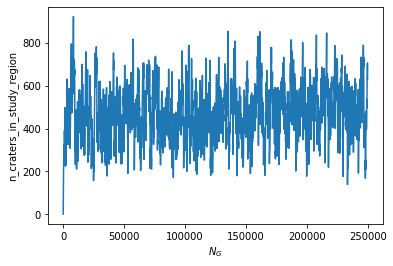

11
Simulation parameters: slope                          0.499877
effective_radius_multiplier    0.988496
r_stat_multiplier              0.987823
min_rim_percentage             0.987398
Name: 0, dtype: float64


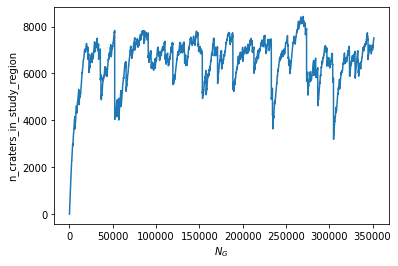

12
Simulation parameters: slope                          0.743693
effective_radius_multiplier    0.257352
r_stat_multiplier              0.987823
min_rim_percentage             0.743954
Name: 0, dtype: float64


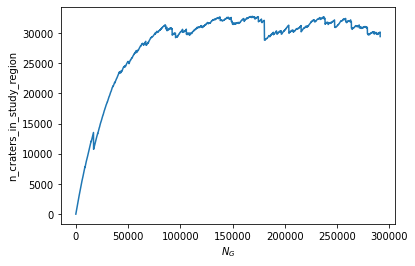

13
Simulation parameters: slope                          0.012245
effective_radius_multiplier    0.988496
r_stat_multiplier              0.499513
min_rim_percentage             0.500511
Name: 0, dtype: float64


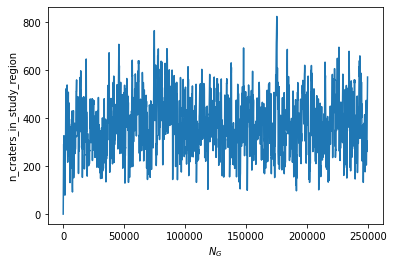

14
Simulation parameters: slope                          0.743693
effective_radius_multiplier    0.257352
r_stat_multiplier              0.987823
min_rim_percentage             0.987398
Name: 0, dtype: float64


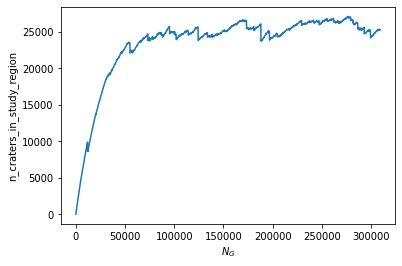

In [47]:
# Visualize CIs for a few in-CCD simulations
for x in range(10, 15):
    print(x)
    plot_holdout_sim_ci(model_configs, in_ccd_paths[x], sample_cadence, metric, inverse_transform=lambda x: x, add_constant=True)

10
Simulation parameters: slope                          0.103897
effective_radius_multiplier    0.804629
r_stat_multiplier              0.632772
min_rim_percentage             0.402547
Name: 0, dtype: float64


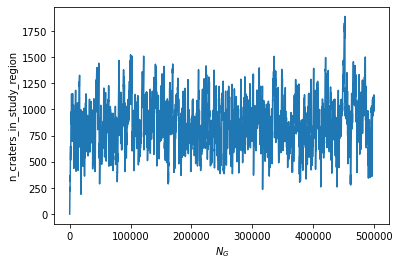

11
Simulation parameters: slope                          0.369842
effective_radius_multiplier    0.602615
r_stat_multiplier              0.363872
min_rim_percentage             0.792643
Name: 0, dtype: float64


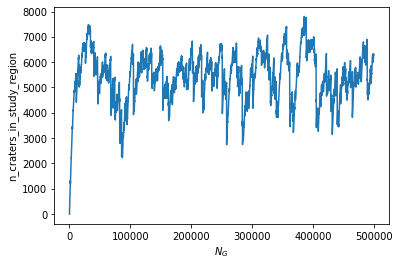

12
Simulation parameters: slope                          0.369842
effective_radius_multiplier    0.805710
r_stat_multiplier              0.635155
min_rim_percentage             0.403134
Name: 0, dtype: float64


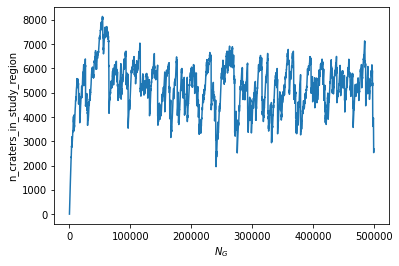

13
Simulation parameters: slope                          0.630501
effective_radius_multiplier    0.599181
r_stat_multiplier              0.906721
min_rim_percentage             0.392029
Name: 0, dtype: float64


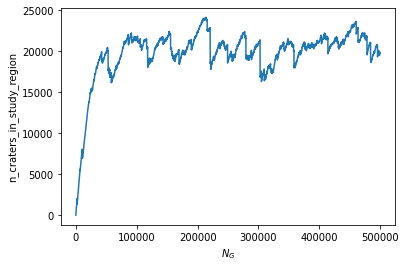

14
Simulation parameters: slope                          0.631295
effective_radius_multiplier    0.599384
r_stat_multiplier              0.094889
min_rim_percentage             0.402638
Name: 0, dtype: float64


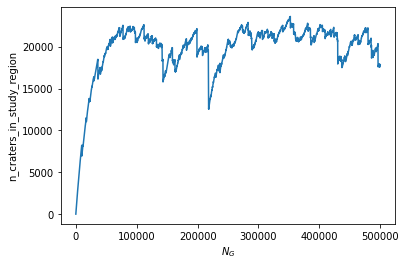

In [48]:
# Visualize CIs for a few simulations outside the CCD
for x in range(10, 15):
    print(x)
    plot_holdout_sim_ci(model_configs, outside_ccd_paths[x], sample_cadence, metric, inverse_transform=lambda x: x, add_constant=True)

In [49]:
# Report for train data
report_models(model_configs, train_df, metric, lambda x: x, True)

Alpha = 0.01, % below: 1.23
Alpha = 0.05, % below: 7.19
Alpha = 0.25, % below: 30.08
Alpha = 0.50, % below: 51.50


In [50]:
# Report for in-CCD test sims
report_models_for_parquets(model_configs, in_ccd_paths, sample_cadence, metric, lambda x: x, True)

Alpha = 0.01, % below: 1.30
Alpha = 0.05, % below: 6.15
Alpha = 0.25, % below: 26.53
Alpha = 0.50, % below: 48.37


In [51]:
# Report for outside-CCD test sims
report_models_for_parquets(model_configs, outside_ccd_paths, sample_cadence, metric, lambda x: x, True)

Alpha = 0.01, % below: 0.17
Alpha = 0.05, % below: 1.35
Alpha = 0.25, % below: 18.67
Alpha = 0.50, % below: 48.48
